# UrbanSound8K DeepLearning Classification

# Introduction

In this project, we focus on developing deep learning–based classifiers for the **UrbanSound8K** dataset, a widely used benchmark that contains 8732 labeled audio excerpts spanning ten everyday urban sound classes, including *car horn*, *dog bark*, *siren*, *engine idling*, *jackhammer*, among others. Each sound clip is no longer than four seconds, presenting challenges related to signal variability, noise, and differences in duration or sampling rate.

The main objective of this work is to design, implement, and evaluate two deep learning architectures, selected from **multilayer perceptrons (MLPs)**, **convolutional neural networks (CNNs)** and **recurrent neural networks (RNNs)**, to classify previously unseen sound excerpts into their respective categories. This involves a complete machine learning pipeline: preprocessing raw audio data, extracting suitable features, defining and training neural network models and assessing their performance through a rigorous **10-fold cross-validation** scheme.

In [32]:
!pip install --break-system-packages -r ../requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import struct
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
import soundfile as sf

from scipy.io import wavfile as wav
from scipy.signal import chirp

# Data Exploration

Before designing any preprocessing pipeline or building models, it is essential to first understand the characteristics of the UrbanSound8K dataset.

The purpose of the data exploration phase is to inspect how the data is structured, examine the metadata, and observe the properties of the audio signals themselves. 

By looking at aspects such as waveform shapes, sampling rates, class distribution, and basic time–frequency representations, we can identify important patterns and potential challenges—such as variable durations, different recording conditions, or inconsistent sampling rates. This initial exploration provides the foundation for the decisions made later in the data preparation phase, ensuring that the preprocessing steps are well-motivated and adapted to the nature of the dataset.

In [3]:
data = pd.read_csv("../UrbanSound8K/metadata/UrbanSound8K.csv")
print(data.shape)

(8732, 8)


In [4]:
data.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [5]:
appended = []
for i in range(1,11):
    appended.append(data[data.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

class   index  jackhammer  dog_bark  drilling  children_playing  \
0       fold1         120       100       100               100   
1       fold2         120       100       100               100   
2       fold3         120       100       100               100   
3       fold4         120       100       100               100   
4       fold5         120       100       100               100   
5       fold6          68       100       100               100   
6       fold7          76       100       100               100   
7       fold8          78       100       100               100   
8       fold9          82       100       100               100   
9      fold10          96       100       100               100   

class  air_conditioner  street_music  engine_idling  siren  car_horn  gun_shot  
0                  100           100             96     86        36        35  
1                  100           100            100     91        42        35  
2                  100           100            107    119        43        36  
3                  100           100            107    166        59        38  
4                  100           100            107     71        98        40  
5                  100           100            107     74        28        46  
6                  100           100            106     77        28        51  
7                  100           100             88     80        30        30  
8                  100           100             89     82        32        31  
9                  100           100             93     83        33        32

In [6]:
print(data['class'].value_counts(normalize=True))

class
dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
street_music        0.114521
jackhammer          0.114521
engine_idling       0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: proportion, dtype: float64


After examining the metadata and overall structure of the dataset, we gained a clearer understanding of how the samples are organized across the 10 folds, how the classes are distributed, and what information accompanies each audio file. This step allowed us to confirm the integrity of the cross-validation setup, identify some class imbalance, and recognize the variety of recording conditions present in the dataset. We will further analyse the dataset with better graphs later, however, with this structural overview in place, we were prepared to look more closely at the audio signals themselves, starting with basic waveform inspection and other signal-level characteristics.

### Plotting wave



In [7]:
def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('../UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

In [8]:
def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  children_playing


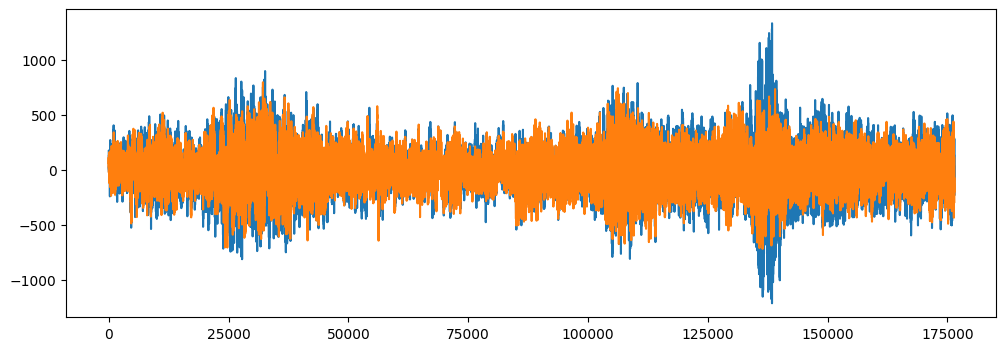

In [9]:
fullpath, label = path_class('100263-2-0-117.wav')
wav_plotter(fullpath,label)

In [10]:
def wav_fmt_parser(file_name):
    full_path, _ = path_class(file_name)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    n_channels_string = riff_fmt[22:24]
    n_channels = struct.unpack("H",n_channels_string)[0]
    s_rate_string = riff_fmt[24:28]
    s_rate = struct.unpack("I",s_rate_string)[0]
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    return (n_channels,s_rate,bit_depth)

In [11]:
wav_fmt_data = [wav_fmt_parser(i) for i in data.slice_file_name]
data[['n_channels','sampling_rate','bit_depth']] = pd.DataFrame(wav_fmt_data)
print(data.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  n_channels  sampling_rate  bit_depth  
0          dog_bark           2          44100         16  
1  children_playing           2          44100         16  
2  children_playing           2          44100         16  
3  children_playing           2          44100         16  
4  children_playing           2          44100         16  


In [12]:
print(data.n_channels.value_counts(), end = "\n\n\n")
print(data.bit_depth.value_counts(), end = "\n\n\n")
print(data.sampling_rate.value_counts())

n_channels
2    7993
1     739
Name: count, dtype: int64


bit_depth
16    5758
24    2753
32     169
8       43
4        9
Name: count, dtype: int64


sampling_rate
44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: count, dtype: int64


After exploring a few representative audio samples and examining their internal WAV format structure using the wav_fmt_parser function, we began to notice that the dataset contains recordings with different technical properties. In particular, the parser allowed us to confirm details such as the number of channels, bit depth, and, most importantly, the sampling rate of each file. This was a key observation, because inconsistent sampling rates imply that the raw audio signals are not directly comparable in their current form. Before applying any preprocessing or feature extraction method, we need to ensure that all samples share a common temporal resolution. This naturally led us to revisit the principles that govern sampling and signal reconstruction, which is why the next step was to consider the Nyquist Sampling Theorem and its implications for our resampling strategy.

## Nyquist Sampling Theorem 


The **Nyquist Sampling Theorem** provides the fundamental rule for converting a continuous signal into a discrete one without losing information. It states that to accurately capture and later reconstruct a signal, the **sampling rate** must be at least **twice the highest frequency** present in that signal. 

Sampling faster than this minimum ensures that the frequency content is preserved, while sampling below it leads to **aliasing**, where different frequencies become indistinguishable.

If a signal contains no frequency components above $f_\text{max}$, then perfect reconstruction is possible as long as the sampling rate satisfies:

$$
f_s \ge 2 f_\text{max}
$$

The value $2 f_\text{max}$ is known as the **Nyquist rate**.

In **audio processing**, this theorem guides how we choose or convert sampling rates to ensure that important sound information is preserved.

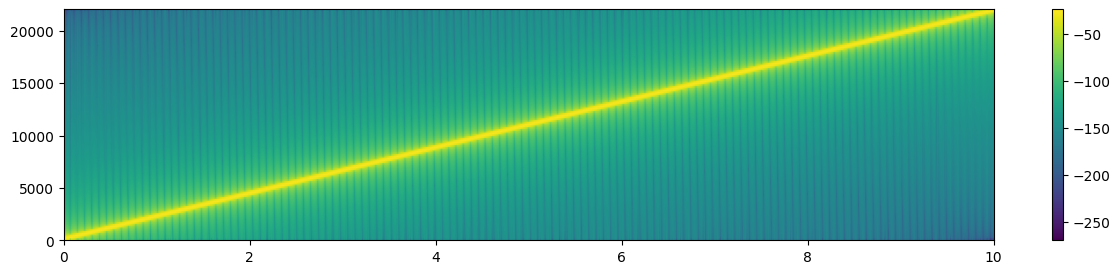

In [ ]:
fs = 44100
T = 10
t = np.linspace(0, T, T*fs, endpoint=False)

w = chirp(t, f0=20, f1=22050, t1=T, method='linear')
sf.write('sine_sweep_44100.wav', w, fs)

plt.figure(figsize=(15,3))
plt.specgram(w, Fs=44100)
plt.colorbar()
_ = plt.axis((0,10,0,22050))
ipd.Audio('sine_sweep_44100.wav')

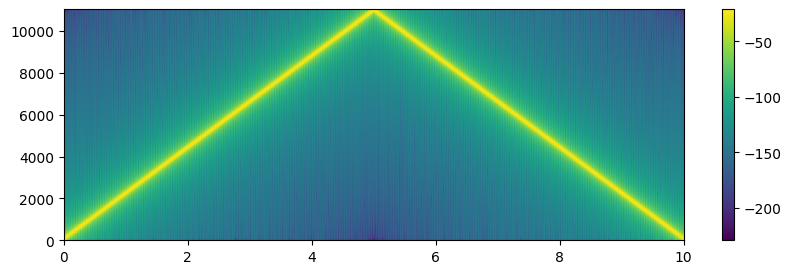

In [ ]:
down_sampled = w[::2]
sf.write('sine_sweep_downsampled.wav', down_sampled, 22050)

plt.figure(figsize=(10,3))
plt.specgram(down_sampled, Fs=22050)
plt.colorbar()
_ = plt.axis((0,10,0,11050))
ipd.Audio('sine_sweep_downsampled.wav')

In conclusion, while the Nyquist-Shannon sampling theorem establishes the theoretical lower bound for sampling rates (2B), the practical implementation of resampling requires careful handling of anti-aliasing to prevent signal distortion.

We now turn our attention to a robust statistical analysis of the UrbanSound8K dataset to understand its class distributions and structural characteristics.

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

In [16]:
METADATA_PATH = '../UrbanSound8K/metadata/UrbanSound8K.csv'
AUDIO_BASE_PATH = '../UrbanSound8K/audio'

In [17]:
def dataset_overview(df):
    """Print comprehensive dataset statistics"""
    print("=" * 60)
    print("URBANSOUND8K DATASET OVERVIEW")
    print("=" * 60)
    print(f"Total samples: {len(df)}")
    print(f"Number of classes: {df['classID'].nunique()}")
    print(f"Number of folds: {df['fold'].nunique()}")
    print(f"\nClass distribution:")
    print(df['class'].value_counts().sort_index())
    print(f"\nSamples per fold:")
    print(df['fold'].value_counts().sort_index())
    print("=" * 60)

def basic_statistics(df):
    """Calculate and display basic statistical measures"""
    stats_dict = {
        'Mean': df.groupby('class')['classID'].count().mean(),
        'Median': df.groupby('class')['classID'].count().median(),
        'Std Dev': df.groupby('class')['classID'].count().std(),
        'Min': df.groupby('class')['classID'].count().min(),
        'Max': df.groupby('class')['classID'].count().max()
    }
    
    print("\nDataset Statistics:")
    for key, value in stats_dict.items():
        print(f"{key}: {value:.2f}")
    
    return stats_dict

In [18]:
def plot_class_distribution(df):
    """Plot class distribution with counts"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar plot
    class_counts = df['class'].value_counts().sort_index()
    ax1.bar(range(len(class_counts)), class_counts.values, color='steelblue')
    ax1.set_xlabel('Class', fontsize=12)
    ax1.set_ylabel('Number of Samples', fontsize=12)
    ax1.set_title('Class Distribution - Bar Chart', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(class_counts)))
    ax1.set_xticklabels(class_counts.index, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Pie chart
    ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('Set3', len(class_counts)))
    ax2.set_title('Class Distribution - Percentage', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_fold_distribution(df):
    """Plot distribution across folds"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    fold_counts = df['fold'].value_counts().sort_index()
    bars = ax.bar(fold_counts.index, fold_counts.values, color='coral')
    
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.set_title('Sample Distribution Across Folds', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_class_fold_heatmap(df):
    """Create heatmap showing class distribution across folds"""
    pivot_table = df.pivot_table(
        values='slice_file_name',
        index='class',
        columns='fold',
        aggfunc='count',
        fill_value=0
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', 
                cbar_kws={'label': 'Number of Samples'})
    plt.title('Class Distribution Across Folds', fontsize=14, fontweight='bold')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Class', fontsize=12)
    plt.tight_layout()
    plt.show()

In [19]:
def load_audio(file_path, sr=22050):
    """Load audio file and return signal and sample rate"""
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def plot_waveform(y, sr, title="Audio Waveform"):
    """Plot audio waveform"""
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(y, sr, title="Spectrogram"):
    """Plot spectrogram"""
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_mel_spectrogram(y, sr, title="Mel Spectrogram"):
    """Plot mel-scaled spectrogram"""
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Mel Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_mfcc(y, sr, n_mfcc=13, title="MFCC Features"):
    """Plot Mel-frequency cepstral coefficients"""
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='RdBu_r')
    plt.colorbar(label='MFCC Coefficient Value')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('MFCC Coefficients', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_chromagram(y, sr, title="Chromagram"):
    """Plot chromagram"""
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='plasma')
    plt.colorbar(label='Magnitude')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Pitch Class', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_spectral_centroid(y, sr, title="Spectral Centroid"):
    """Plot spectral centroid over time"""
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    times = librosa.times_like(cent, sr=sr)
    
    plt.figure(figsize=(14, 4))
    plt.plot(times, cent.T, color='steelblue', linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_zero_crossing_rate(y, title="Zero Crossing Rate"):
    """Plot zero crossing rate over time"""
    zcr = librosa.feature.zero_crossing_rate(y)
    frames = range(len(zcr[0]))
    
    plt.figure(figsize=(14, 4))
    plt.plot(frames, zcr[0], color='green', linewidth=1.5)
    plt.xlabel('Frame', fontsize=12)
    plt.ylabel('Zero Crossing Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_spectral_rolloff(y, sr, title="Spectral Rolloff"):
    """Plot spectral rolloff over time"""
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    times = librosa.times_like(rolloff, sr=sr)
    
    plt.figure(figsize=(14, 4))
    plt.plot(times, rolloff.T, color='purple', linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [20]:
def analyze_audio_comprehensive(file_path, class_name="Unknown", sr=22050):
    """Perform comprehensive analysis on a single audio file"""
    y, sr = load_audio(file_path, sr)
    
    print(f"\n{'='*60}")
    print(f"Audio Analysis: {class_name}")
    print(f"{'='*60}")
    print(f"Duration: {len(y)/sr:.2f} seconds")
    print(f"Sample rate: {sr} Hz")
    print(f"Number of samples: {len(y)}")
    print(f"Max amplitude: {np.max(np.abs(y)):.4f}")
    print(f"Mean amplitude: {np.mean(np.abs(y)):.4f}")
    
    # Plot all visualizations
    plot_waveform(y, sr, f"Waveform - {class_name}")
    plot_spectrogram(y, sr, f"Spectrogram - {class_name}")
    plot_mel_spectrogram(y, sr, f"Mel Spectrogram - {class_name}")
    plot_mfcc(y, sr, title=f"MFCC - {class_name}")
    plot_chromagram(y, sr, f"Chromagram - {class_name}")
    plot_spectral_centroid(y, sr, f"Spectral Centroid - {class_name}")
    plot_zero_crossing_rate(y, f"Zero Crossing Rate - {class_name}")
    plot_spectral_rolloff(y, sr, f"Spectral Rolloff - {class_name}")

def extract_features(y, sr):
    """Extract multiple audio features"""
    features = {}
    
    # Temporal features
    features['duration'] = len(y) / sr
    features['mean_amplitude'] = np.mean(np.abs(y))
    features['max_amplitude'] = np.max(np.abs(y))
    features['rms_energy'] = np.sqrt(np.mean(y**2))
    
    # Spectral features
    features['zcr_mean'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['zcr_std'] = np.std(librosa.feature.zero_crossing_rate(y))
    
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
    
    # MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i}_std'] = np.std(mfccs[i])
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    
    return features

def compare_classes_features(file_paths, class_names, sr=22050):
    """Compare features across multiple audio classes"""
    all_features = []
    
    for file_path, class_name in zip(file_paths, class_names):
        y, sr = load_audio(file_path, sr)
        features = extract_features(y, sr)
        features['class'] = class_name
        all_features.append(features)
    
    features_df = pd.DataFrame(all_features)
    
    # Plot comparison
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns[:8]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols):
        axes[idx].bar(features_df['class'], features_df[col], color=sns.color_palette('husl', len(class_names)))
        axes[idx].set_title(col.replace('_', ' ').title(), fontsize=10, fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return features_df

In [21]:
def analyze_class_samples(df, audio_base_path, class_name, num_samples=3, sr=22050):
    """Analyze multiple samples from a specific class"""
    class_df = df[df['class'] == class_name].head(num_samples)
    
    for idx, row in class_df.iterrows():
        file_path = f"{audio_base_path}/fold{row['fold']}/{row['slice_file_name']}"
        y, sr = load_audio(file_path, sr)
        
        print(f"\n--- Sample {idx+1} ---")
        print(f"File: {row['slice_file_name']}")
        
        plot_waveform(y, sr, f"{class_name} - Sample {idx+1}")
        plot_mel_spectrogram(y, sr, f"{class_name} Mel Spectrogram - Sample {idx+1}")

In [22]:
def plot_channel_distribution_from_files(df, audio_base_path):
    """
    Analyzes all audio files in the dataset to determine if they are Mono (1) 
    or Stereo (2) and plots the distribution.
    """
    channel_counts = []
    print("Starting audio channel analysis. This will take a moment as it checks 8732 files...")
    
    for index, row in df.iterrows():
        file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
        
        try:
            y, sr = librosa.load(file_path, sr=None, mono=False, duration=0.01)
            
            # Check the shape: 1D array is Mono, 2D array (channels x samples) is Stereo/Multi
            if y.ndim == 1:
                channel_counts.append("Mono (1)")
            elif y.ndim == 2 and y.shape[0] == 2:
                channel_counts.append("Stereo (2)")
            else:
                channel_counts.append(f"Multi ({y.shape[0]})")
                
        except Exception as e:
            channel_counts.append("Error/Missing")

    channel_series = pd.Series(channel_counts)
    counts = channel_series.value_counts()
    
    counts_ordered = counts.reindex(['Mono (1)', 'Stereo (2)', 'Multi (3+)', 'Error/Missing'], fill_value=0)
    counts_ordered = counts_ordered[counts_ordered > 0]
    
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=counts_ordered.index, y=counts_ordered.values, palette="viridis")
    
    plt.title('Distribution of Audio Channels in UrbanSound8K', fontsize=15)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Channel Type', fontsize=12)
    
    plt.bar_label(ax.containers[0], padding=3)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    print("\n--- Channel Analysis Summary ---")
    print(counts_ordered)

In [23]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv(METADATA_PATH)

In [24]:
dataset_overview(df)
basic_statistics(df)

URBANSOUND8K DATASET OVERVIEW
Total samples: 8732
Number of classes: 10
Number of folds: 10

Class distribution:
class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: count, dtype: int64

Samples per fold:
fold
1     873
2     888
3     925
4     990
5     936
6     823
7     838
8     806
9     816
10    837
Name: count, dtype: int64

Dataset Statistics:
Mean: 873.20
Median: 1000.00
Std Dev: 249.93
Min: 374.00
Max: 1000.00


{'Mean': np.float64(873.2),
 'Median': np.float64(1000.0),
 'Std Dev': np.float64(249.92790071449718),
 'Min': np.int64(374),
 'Max': np.int64(1000)}

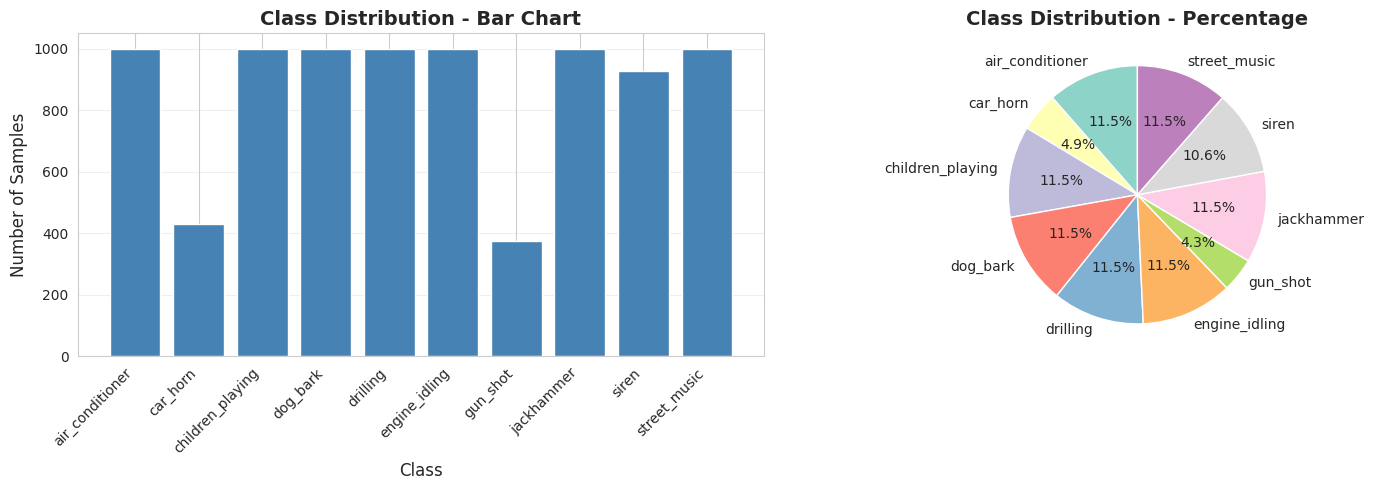

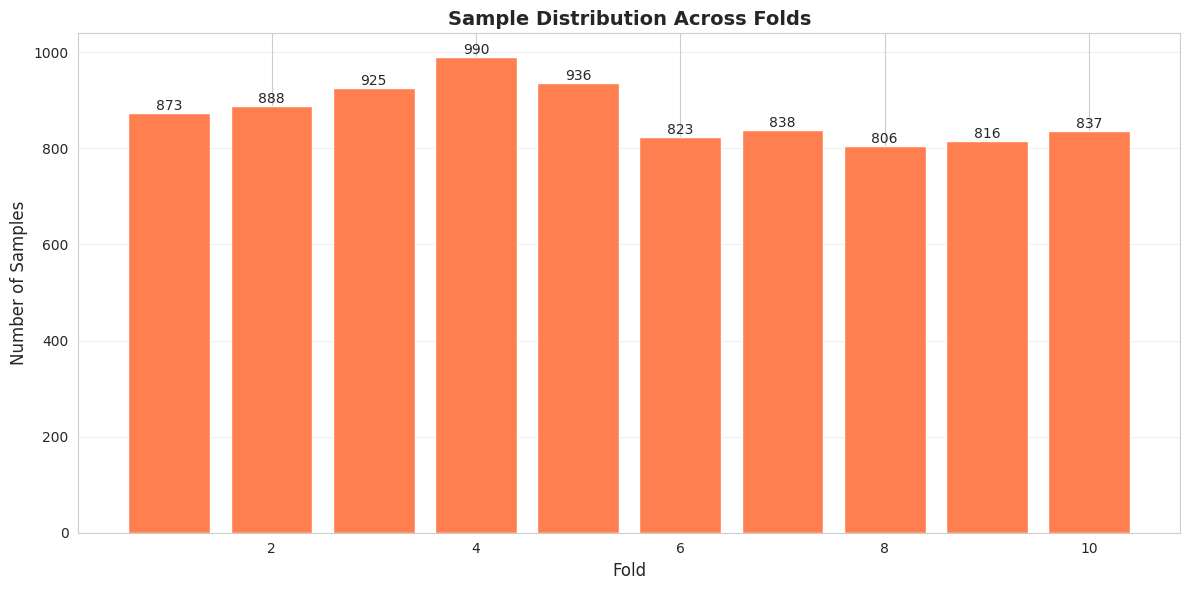

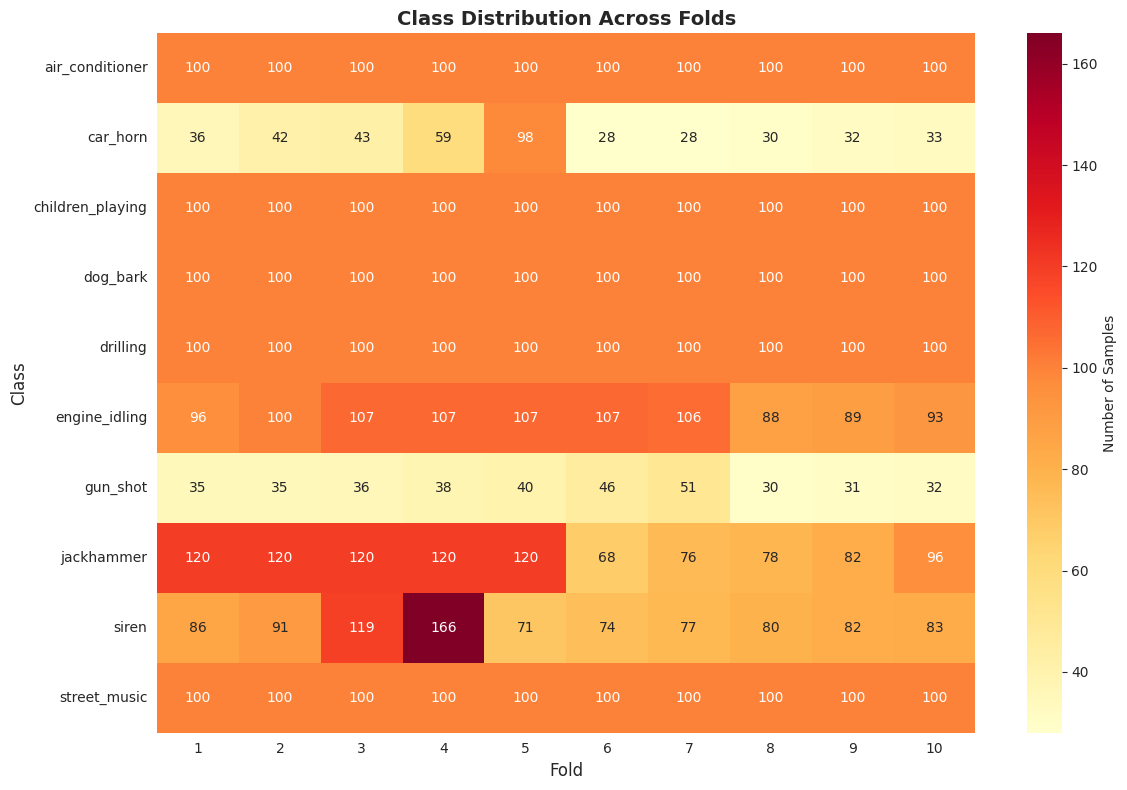

In [25]:
plot_class_distribution(df)
plot_fold_distribution(df)
plot_class_fold_heatmap(df)

Starting audio channel analysis. This will take a moment as it checks 8732 files...


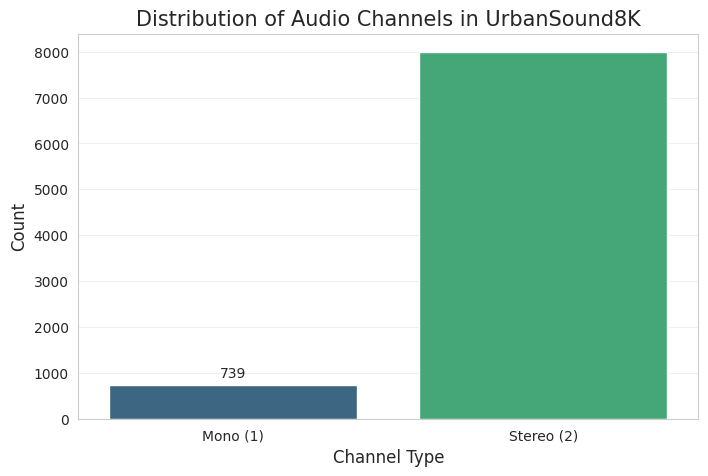


--- Channel Analysis Summary ---
Mono (1)       739
Stereo (2)    7993
Name: count, dtype: int64


In [26]:
plot_channel_distribution_from_files(df, AUDIO_BASE_PATH)

In [27]:
def get_audio_path(df, audio_base_path, index=0):
    """
        Helper function to get a valid audio file path from the dataframe
        """
    row = df.iloc[index]
    file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Audio file not found: {file_path}")
    
    return file_path, row['class']

def get_class_audio_path(df, audio_base_path, class_name, index=0):
    """
        Get audio file path for a specific class
        """
    class_df = df[df['class'] == class_name]
    
    if len(class_df) == 0:
        raise ValueError(f"No samples found for class: {class_name}")
    
    if index >= len(class_df):
        raise ValueError(f"Index {index} out of range. Class has {len(class_df)} samples")
    
    row = class_df.iloc[index]
    file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Audio file not found: {file_path}")
    
    return file_path, row['class']


Audio Analysis: dog_bark
Duration: 0.32 seconds
Sample rate: 22050 Hz
Number of samples: 7002
Max amplitude: 0.9859
Mean amplitude: 0.0901


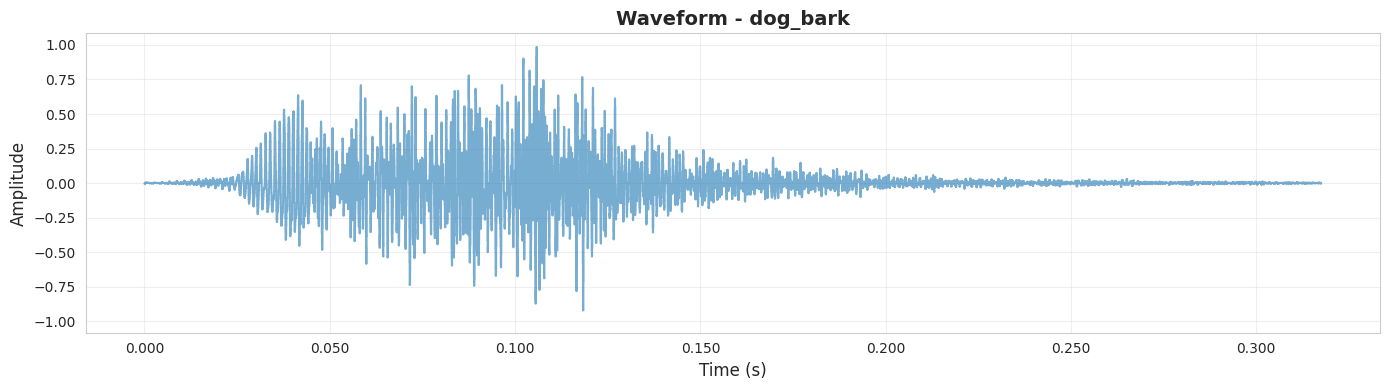

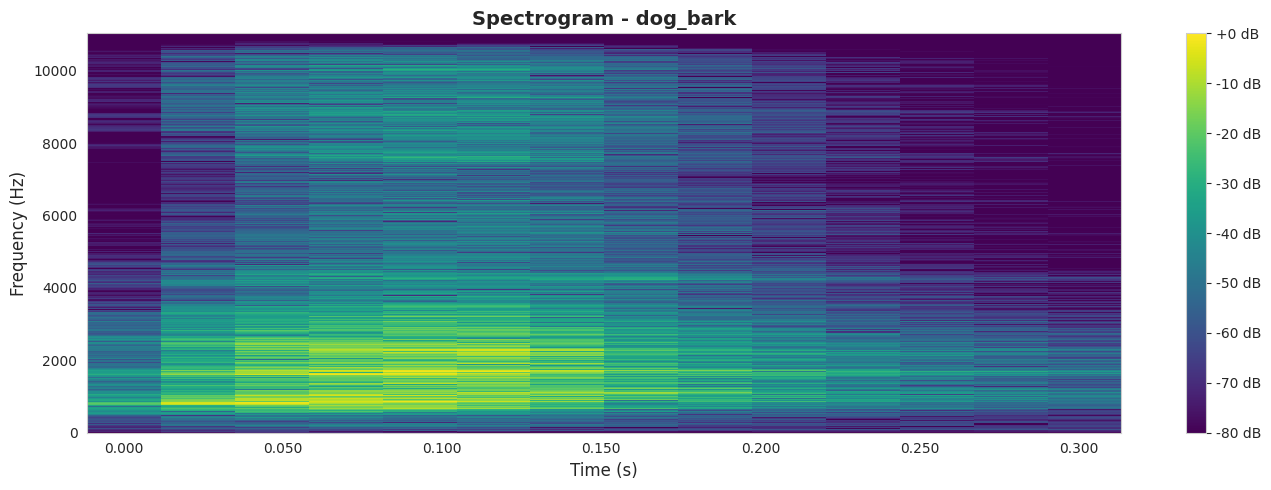

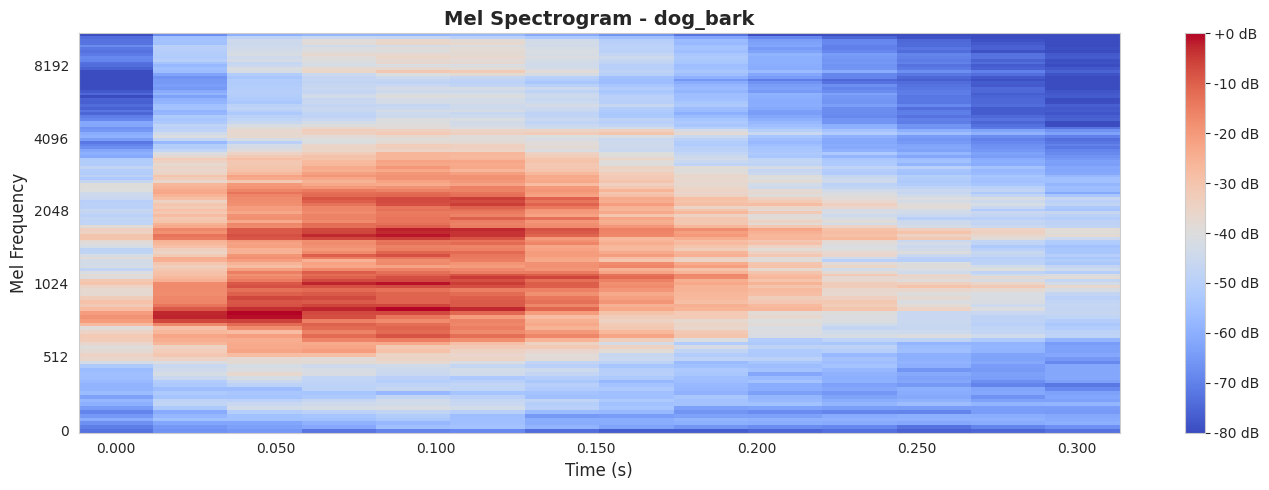

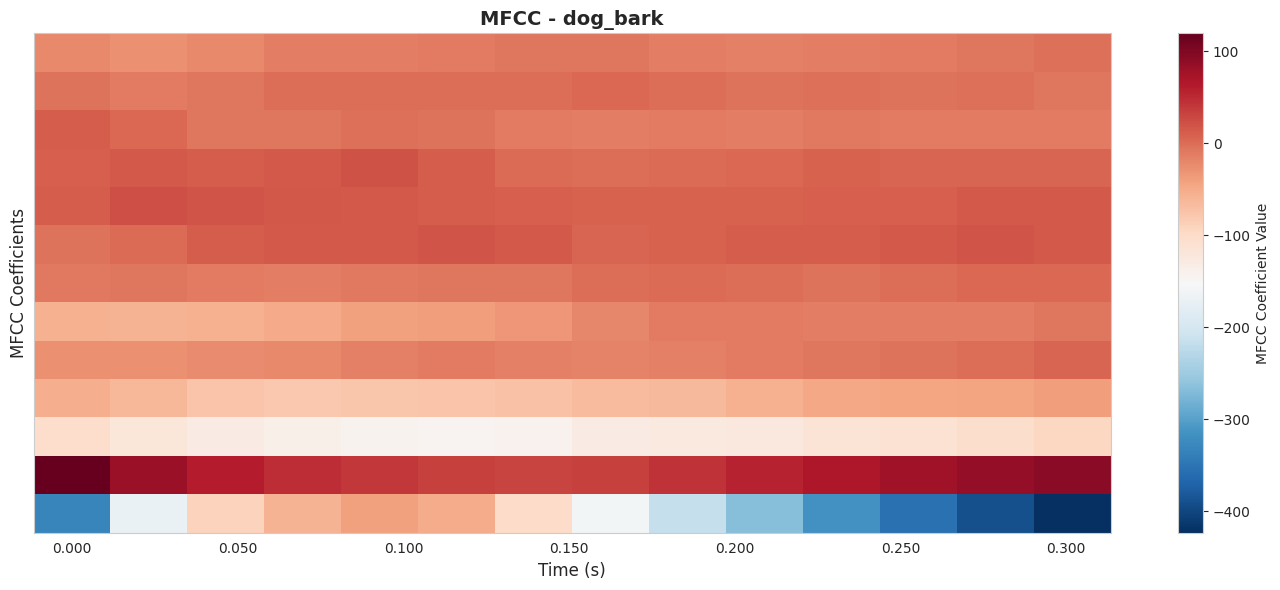

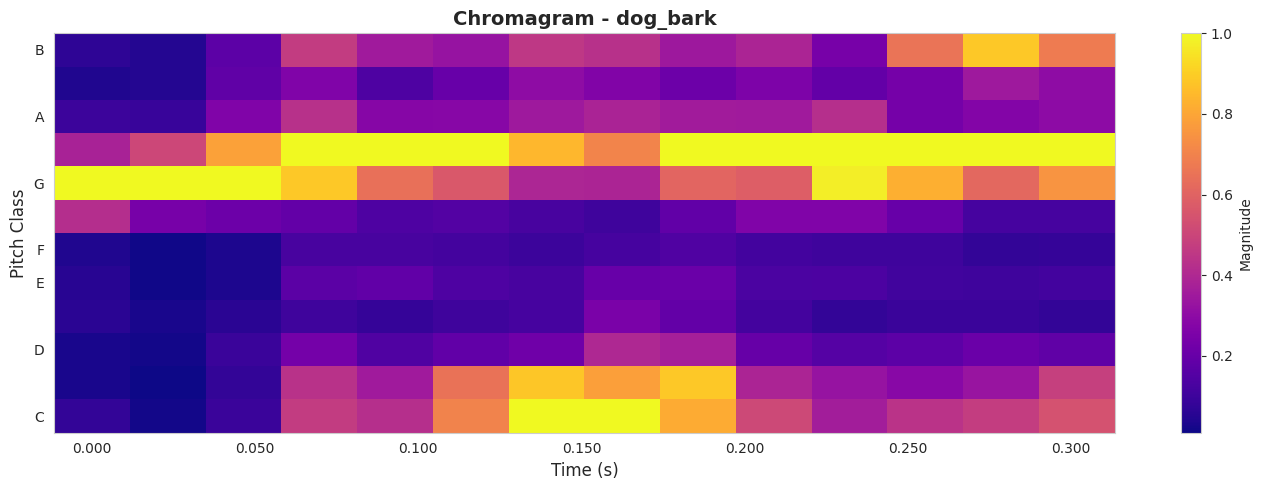

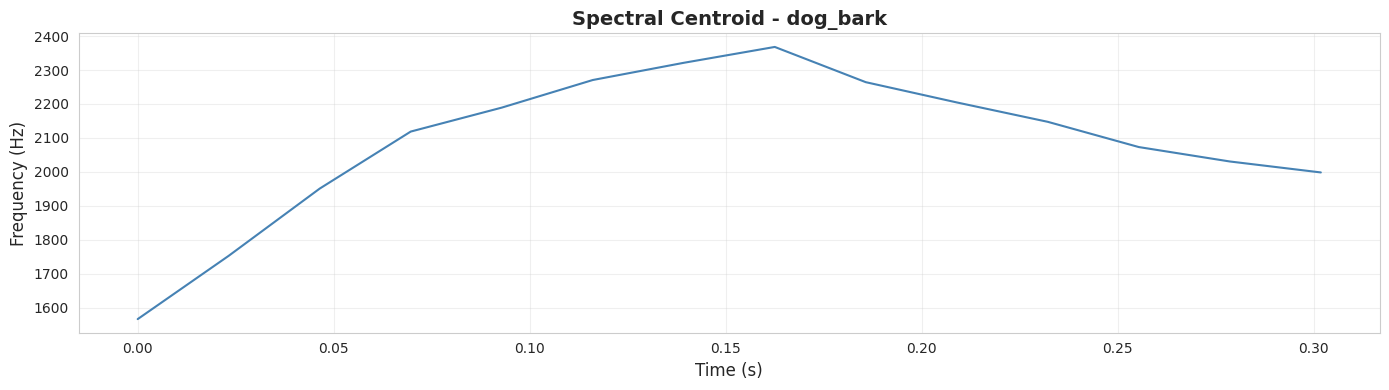

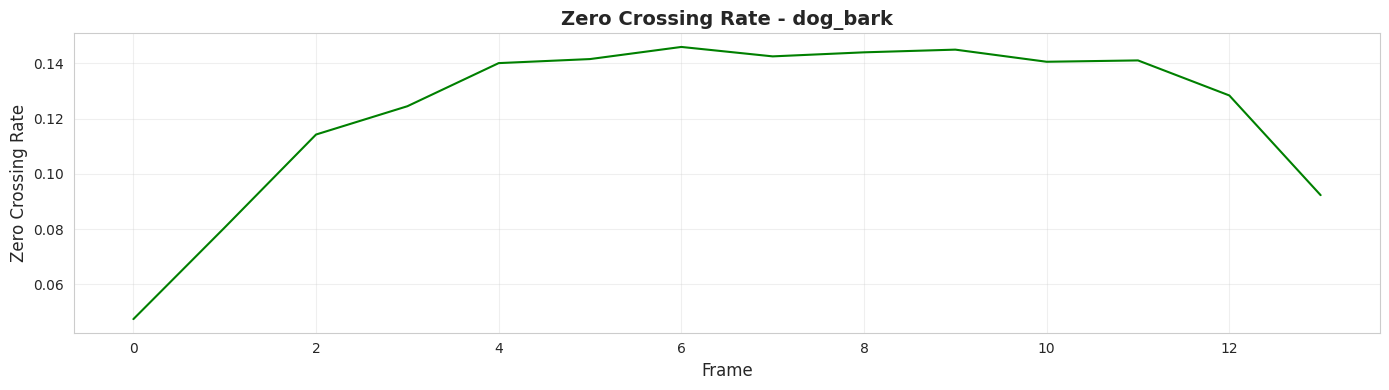

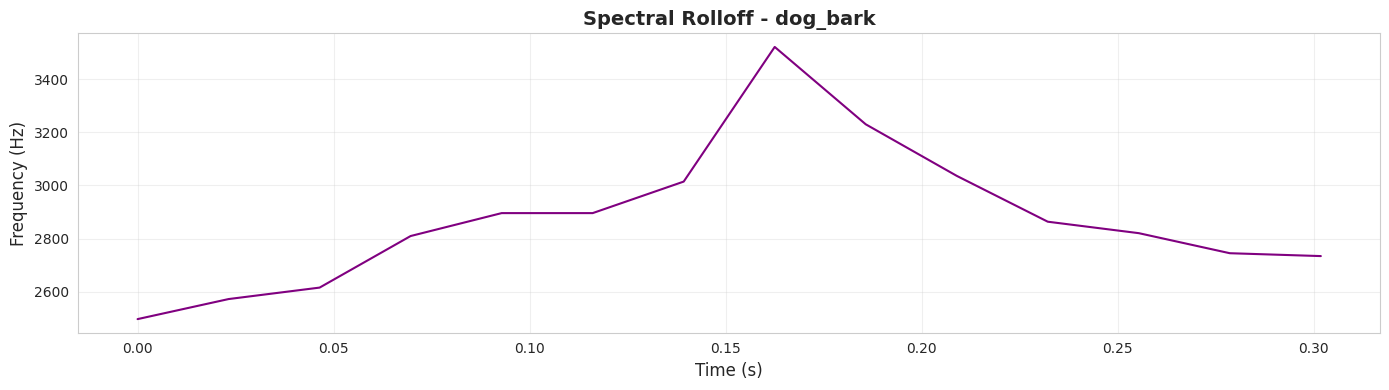

In [28]:
file_path, class_name = get_class_audio_path(df, AUDIO_BASE_PATH, 'dog_bark', index=0)
analyze_audio_comprehensive(file_path, class_name=class_name)


--- Sample 115 ---
File: 102853-8-0-0.wav


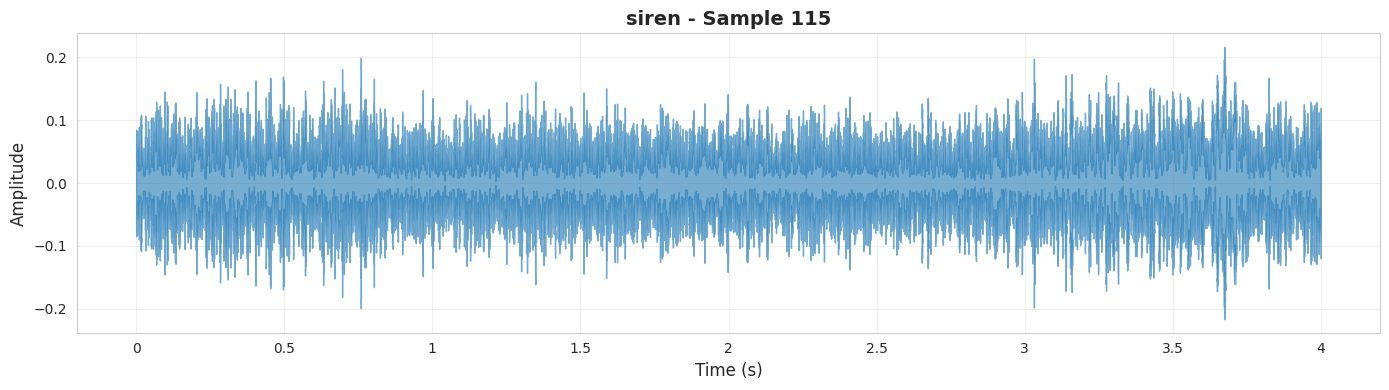

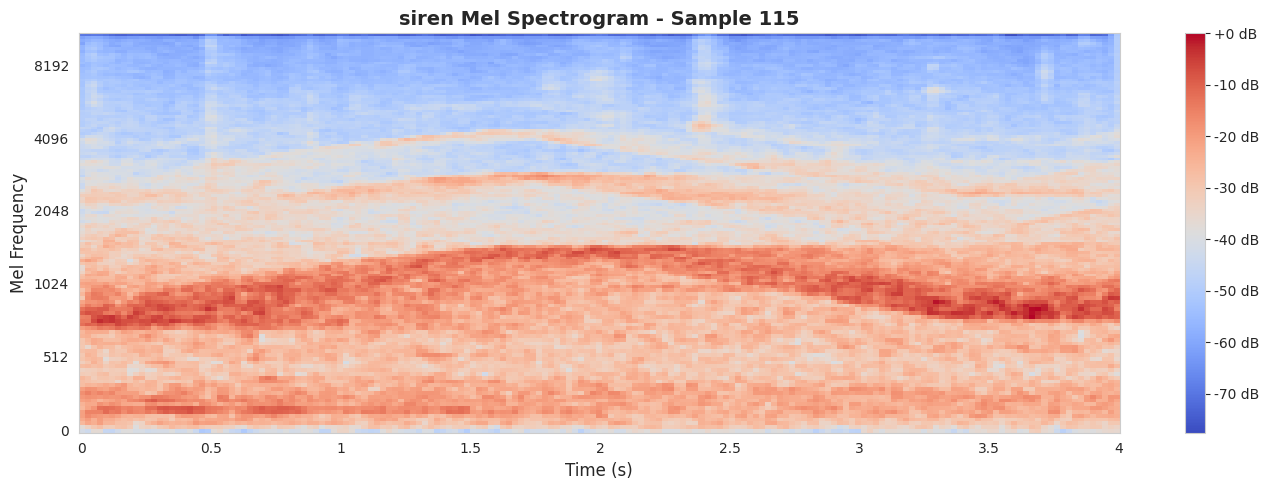


--- Sample 116 ---
File: 102853-8-0-1.wav


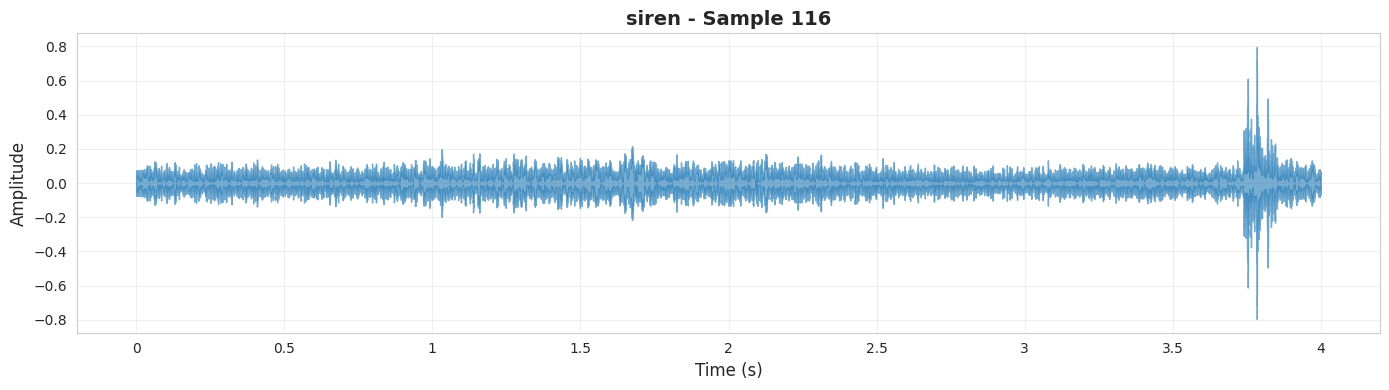

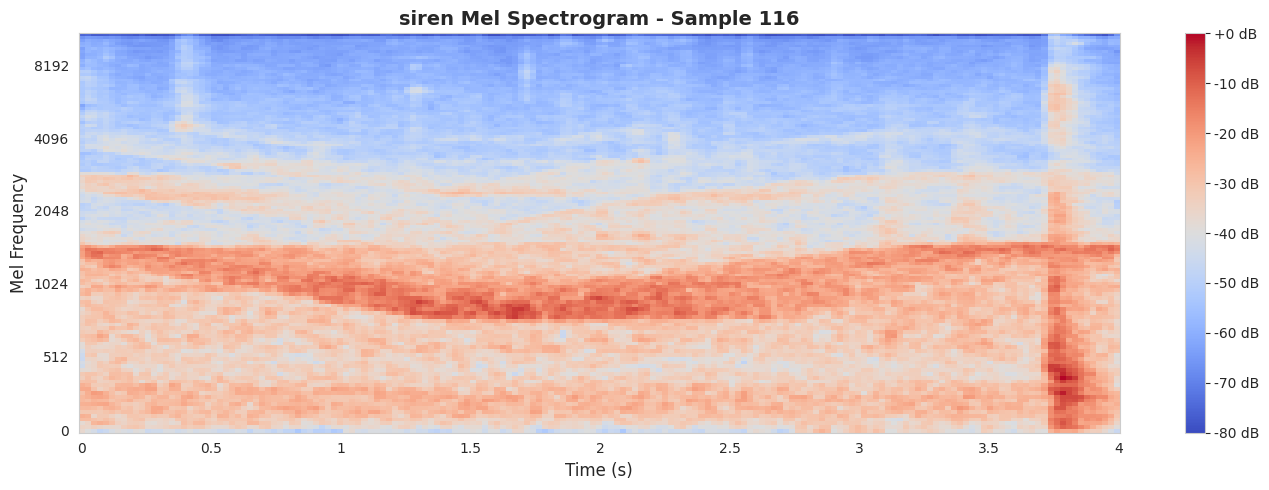


--- Sample 117 ---
File: 102853-8-0-2.wav


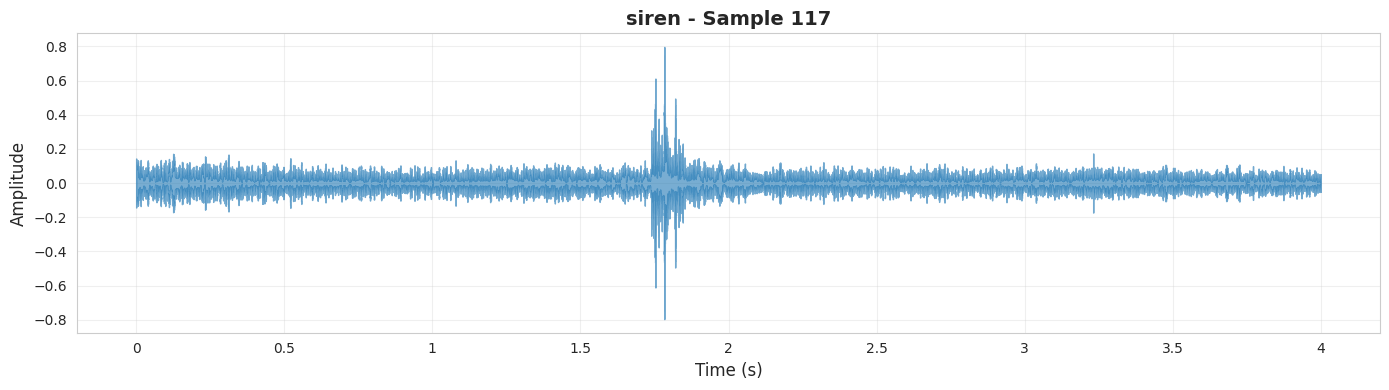

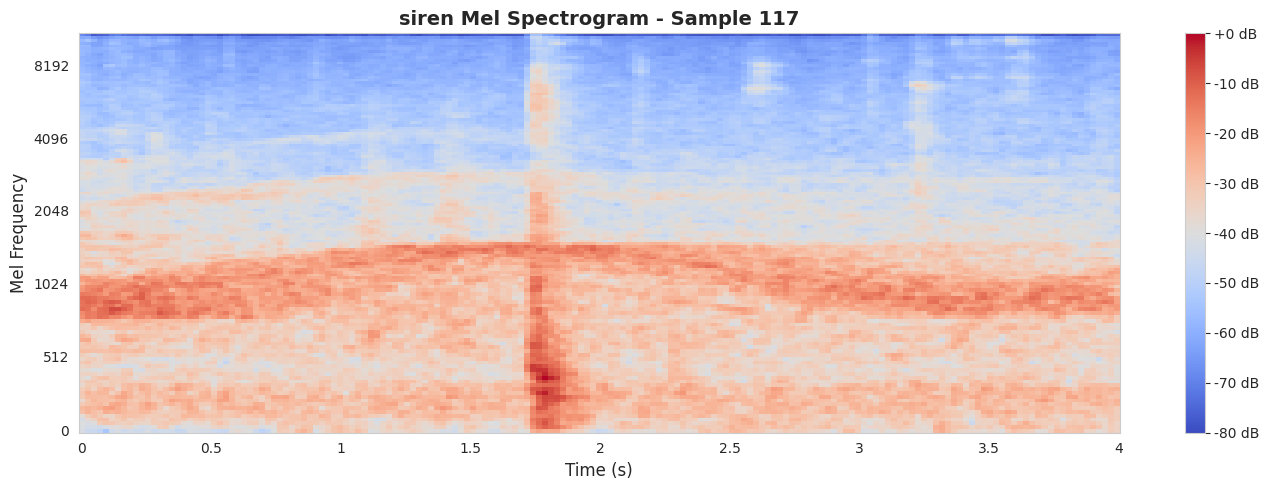

In [30]:
analyze_class_samples(df, AUDIO_BASE_PATH, 'siren', num_samples=3)

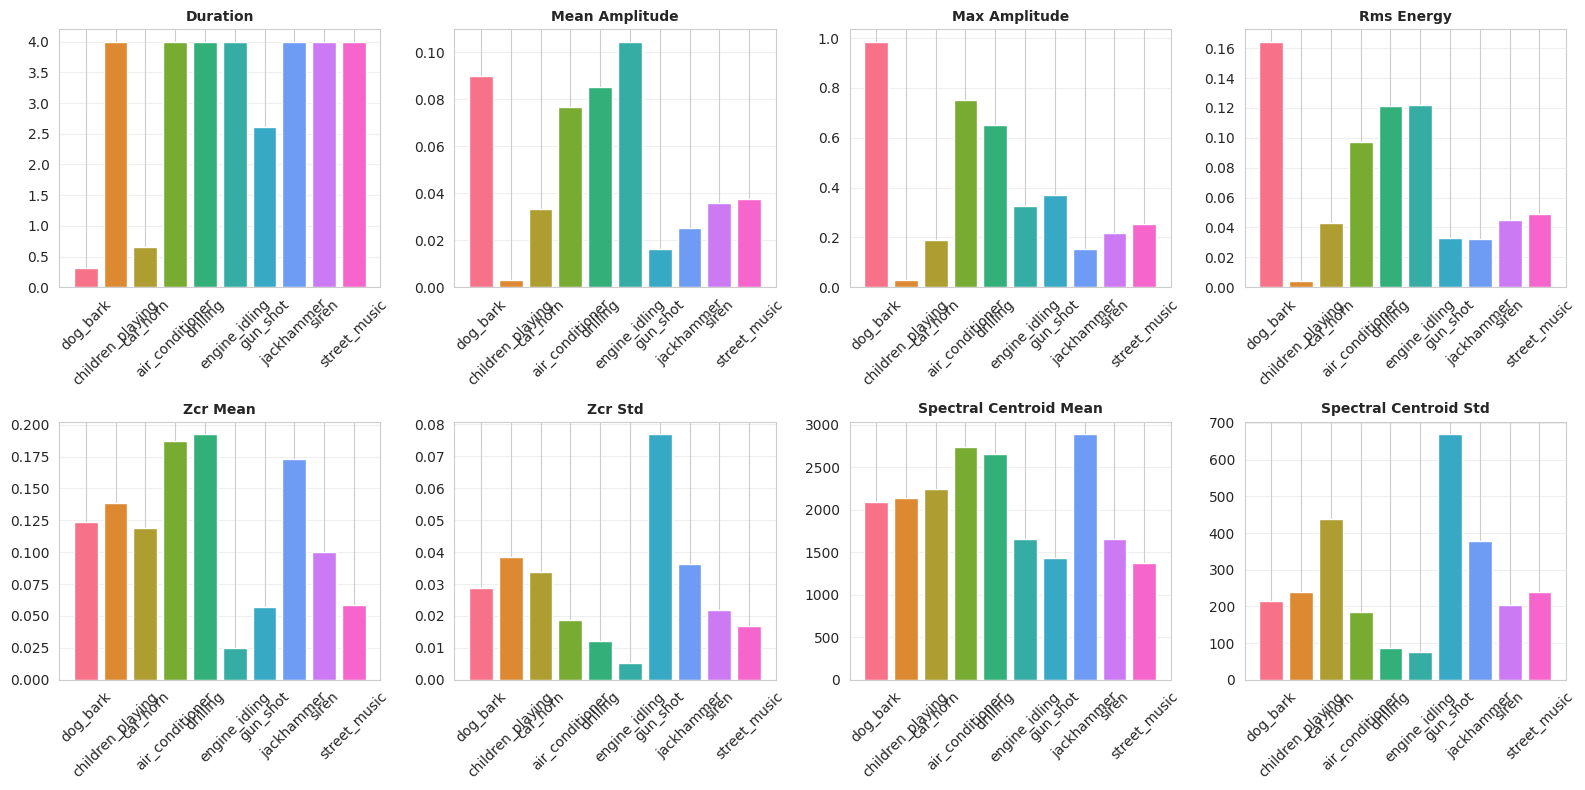

   duration  mean_amplitude  max_amplitude  rms_energy  zcr_mean   zcr_std  \
0  0.317551        0.090059       0.985863    0.164392  0.123465  0.028894   
1  4.000000        0.003199       0.027128    0.004148  0.138779  0.038332   
2  0.648526        0.033357       0.188049    0.043128  0.119106  0.033918   
3  4.000000        0.076732       0.750014    0.097175  0.186989  0.018589   
4  4.000000        0.085406       0.650571    0.121458  0.192583  0.012227   
5  4.000000        0.104634       0.325730    0.122160  0.024708  0.005243   
6  2.610023        0.016379       0.369727    0.032722  0.056943  0.076965   
7  4.000000        0.025449       0.155487    0.032329  0.173413  0.036320   
8  4.000000        0.035773       0.216774    0.045287  0.100501  0.021779   
9  4.000000        0.037689       0.254737    0.049055  0.058455  0.016838   

   spectral_centroid_mean  spectral_centroid_std  spectral_rolloff_mean  \
0             2089.849972             213.673961            2875.4

In [31]:
file_paths = []
class_names = []
for class_name in ['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
                   'drilling', 'engine_idling', 'gun_shot', 'jackhammer',  'siren', 'street_music']:
    fp, cn = get_class_audio_path(df, AUDIO_BASE_PATH, class_name, index=0)
    file_paths.append(fp)
    class_names.append(cn)

features_comparison = compare_classes_features(file_paths, class_names)
print(features_comparison)

The statistical analysis of the UrbanSound8K metadata reveals a significant class imbalance that must be addressed during model training.

As illustrated in the class distribution plot, while the majority of classes (such as 'jackhammer', 'engine_idling', and 'air_conditioner') contain approximately 1000 samples each, minority classes like 'car_horn' and 'gun_shot' typically contain fewer than 430 samples. This results in an imbalance ratio of approximately 2.3:1 between the majority and minority classes, which could bias the model toward the more frequent sounds.

Furthermore, the fold distribution shows slight variations in sample counts, requiring careful handling during cross-validation to ensure fair evaluation. These findings indicate that our data preparation pipeline must standardise the input signals not only in terms of sampling rate and duration but also potentially employ augmentation strategies to mitigate the scarcity of data in the minority classes.